# Описание проекта
Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

In [5]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats as st
warnings.simplefilter('ignore')

In [6]:
# Загрузим данные
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
# Посмотрим на общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


6 колонок с пропусками, из них 2 всего лишь с 2 пропусками и 1 с 269 пропусками 

## Предобработка данных

**Названия столбцов не соответствуют `snake_case`. Исправим нужным образом**

In [8]:
df.columns = map(str.lower, df.columns)
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Проверим датафрейм на наличие явных дубликатов**

In [9]:
df.duplicated().value_counts()

False    16715
dtype: int64

Явных дубликатов не обнаружено

**Изменим типы данных по необходимости**

In [10]:
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

- `year_of_release` должна быть типа `int`, поскольку это год
- `user_score` должна быть `float`, поскольку в неё входят дробные числа

In [11]:
df = df.astype({'year_of_release': 'Int64'})

В колонке `user_score` попадается аббревиатура *tbd – to be determined (должно быть определено).*<br>
По значению этот сигнал близок к пустому, поэтому изменим все **tbd** на **Nan**, а затем переведём тип данных в `float`

In [12]:
df.user_score.replace('tbd', np.nan, inplace=True)
df.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [13]:
# Преобразуем этот тип данных и проверим итог всех изменений
df.user_score = df.user_score.astype('float')
df.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

**Обработаем пропуски**

In [14]:
# Выведем список колонок с пропусками
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

user_score         9125
critic_score       8578
rating             6766
year_of_release     269
name                  2
genre                 2
dtype: int64

Заполним пропуски в `user_score` и `critic_score` заглушками

In [15]:
# Заполним пропуски отрицательными цифрами
df[['user_score', 'critic_score']] = df[['user_score', 'critic_score']].fillna(-1)

Пропуски в `rating` также заполним заглушкой

In [16]:
df['rating'] = df['rating'].fillna('0')

Строки с пропусками в `year_of_release`, `name` и `genre` за счёт малочисленности уберём из датафрейма

In [17]:
df.dropna(subset=['year_of_release', 'name', 'genre'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

Пропуски устранены

**Посчитаем суммарные продажи по всем регионам и создадим отдельный столбец**

In [18]:
df.insert(8, column='total_sales', value=(df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']))
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,-1.0,-1.0,0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,-1.0,-1.0,0


In [19]:
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   total_sales      16444 non-null  float64
 9   critic_score     16444 non-null  float64
 10  user_score       16444 non-null  float64
 11  rating           16444 non-null  object 
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ данных

**Проанализируем количество игр в зависимости от года релиза**

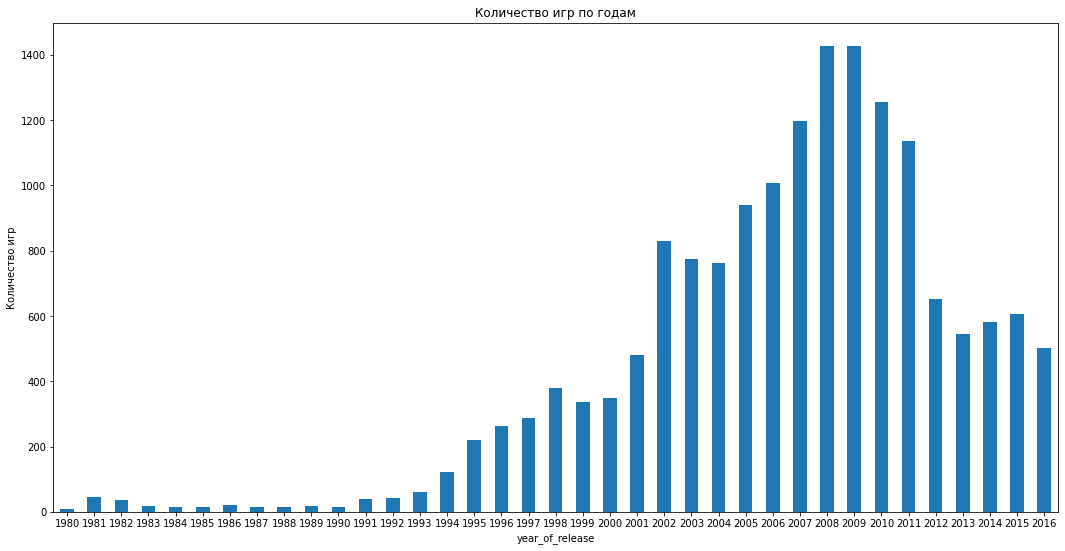

In [20]:
df.groupby('year_of_release')['name'].count().plot.bar(figsize=(18,9), rot=0)
plt.title('Количество игр по годам');
plt.ylabel('Количество игр');

In [21]:
df.groupby('year_of_release')['platform'].count()

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: platform, dtype: int64

`C 2002 по 2011 года` наблюдается `наибольшее количество` выпущенных игр<br>
`С 1980 по 1994 года` – наблюдается `наименьшее количество`, что обусловлено, скорее всего, малым разнообразием игровых платформ

**Проанализируем продажи игр в завивимости от платформ**

Выделим 10 платформ с наибольшими суммами продаж игр и построим таблицу этих продаж по годам

In [22]:
costly_games = df.groupby('platform')[['total_sales']].sum().sort_values('total_sales', ascending=False).head(10).index
df[df['platform'].isin(costly_games)].groupby('year_of_release')[['platform']].count()
piv = df[df['platform'].isin(costly_games)].pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='count')
piv

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1985,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,164.0,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,188.0,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN
2000,NaN,NaN,1.0,160.0,82.0,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,107.0,91.0,185.0,NaN,NaN,NaN,NaN,NaN


Посчитаем, сколько лет в среднем консоль держится на рынке<br>
Однако перед этим уберём одну аномалию: консоль Nintendo DS была выпущена в 2004 году. Уберём строчку с 1985 годом этой консоли

In [23]:
# Найдём индекс строки с аномалией
i_to_drop = df[(df['platform'] == 'DS') & (df['year_of_release'] == 1985)].index

In [24]:
# Перезапишем наш датафрейм без аномалии и выведем отредактированную сводную таблицу
df = df.drop(i_to_drop)
df.reset_index(drop=True, inplace=True)
piv = df[df['platform'].isin(costly_games)].pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='count')
piv.style.highlight_between(left=0, color='springgreen')

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1994,nan,nan,nan,17.000000,nan,nan,nan,nan,nan,nan
1995,nan,nan,nan,99.000000,nan,nan,nan,nan,nan,nan
1996,nan,nan,nan,164.000000,nan,nan,nan,nan,nan,nan
1997,nan,nan,nan,188.000000,nan,nan,nan,nan,nan,nan
1998,nan,nan,nan,248.000000,nan,nan,nan,nan,nan,nan
1999,nan,nan,nan,200.000000,nan,nan,nan,nan,nan,nan
2000,nan,nan,1.000000,160.000000,82.000000,nan,nan,nan,nan,nan
2001,nan,nan,107.000000,91.000000,185.000000,nan,nan,nan,nan,nan
2002,nan,nan,198.000000,20.000000,280.000000,nan,nan,nan,nan,nan


In [25]:
# Посчитаем среднее количество лет актуальности консоли
mean_life_console = []

for console in piv.columns:
    mean_life_console.append(piv[console].count())
    
mean_life_console = round(sum(mean_life_console) / len(mean_life_console))
mean_life_console

10

In [26]:
# Посмотрим на данные за последние 10 лет и за последний год. Сравним выборки
print('За последние 10 лет')
display(df[df['year_of_release'] >= 2007].groupby('platform')[['total_sales']].sum().sort_values('total_sales', ascending=False).head(10))
print('За последний год')
df[df['year_of_release'] == 2016].groupby('platform')[['total_sales']].sum().sort_values('total_sales', ascending=False)

За последние 10 лет


,total_sales
platform,
PS3,910.38
X360,901.37
Wii,754.03
DS,535.54
PS4,314.14
3DS,257.81
PSP,183.31
PS2,162.38
PC,160.57


За последний год


,total_sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14
PC,5.25
WiiU,4.60
PSV,4.25
PS3,3.60
X360,1.52
Wii,0.18


- `PS3` – теряет позиции
- `X360` – теряет позиции
- `Wii` – теряет позиции
- `DS` – вышел из топ-10
- `PS4` - <span style="color:blue"> набрала позиции и стала лидером</span>
- `3DS` – <span style="color:blue"> набирает позиции</span>
- `PSP` – вышла из топ-10
- `PS2` – вышла из топ-10
- `PC` – <span style="color:blue"> набирает позиции</span>
- `XOne` – <span style="color:blue"> набирает позиции</span>

`WiiU` и `PSV` – <span style="color:blue"> попали в девятку актуальных за 2016 год</span>

Создадим копию датасета, в которой оставим актуальный период (2015-2016 гг.)

In [27]:
df_all = df.copy()
df = df[df['year_of_release'] >= 2013]
df = df.reset_index(drop=True)

**Построим boxplot каждой платформы с глобальными продажами**

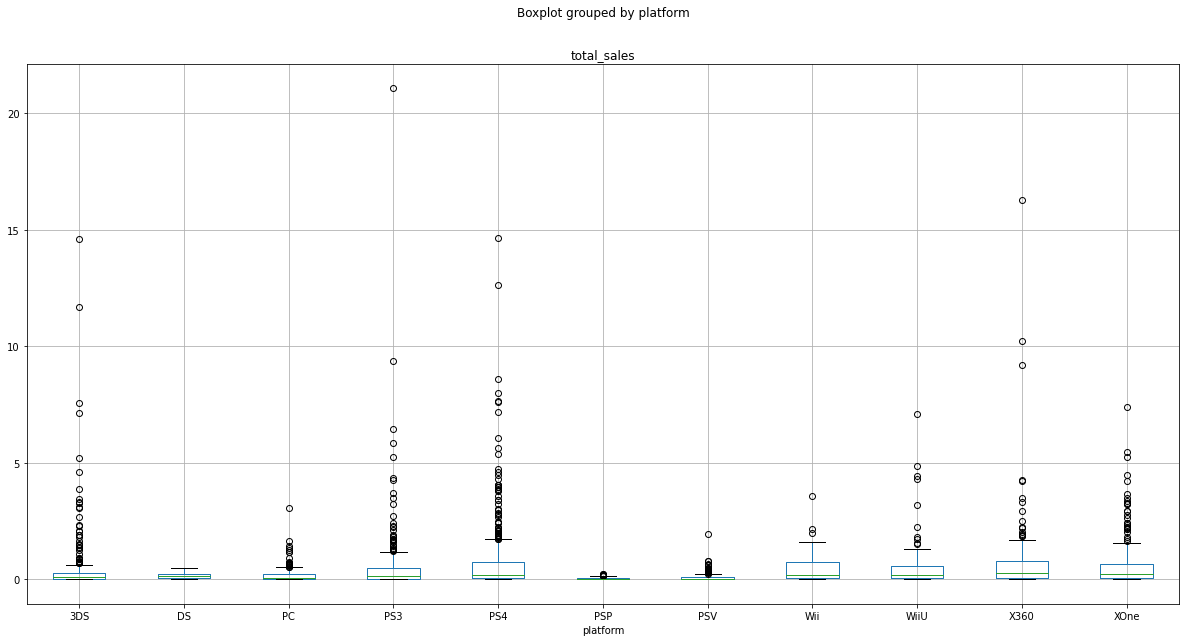

In [28]:
df.boxplot(column='total_sales', by='platform', figsize=(20,10));

(0.0, 5.0)

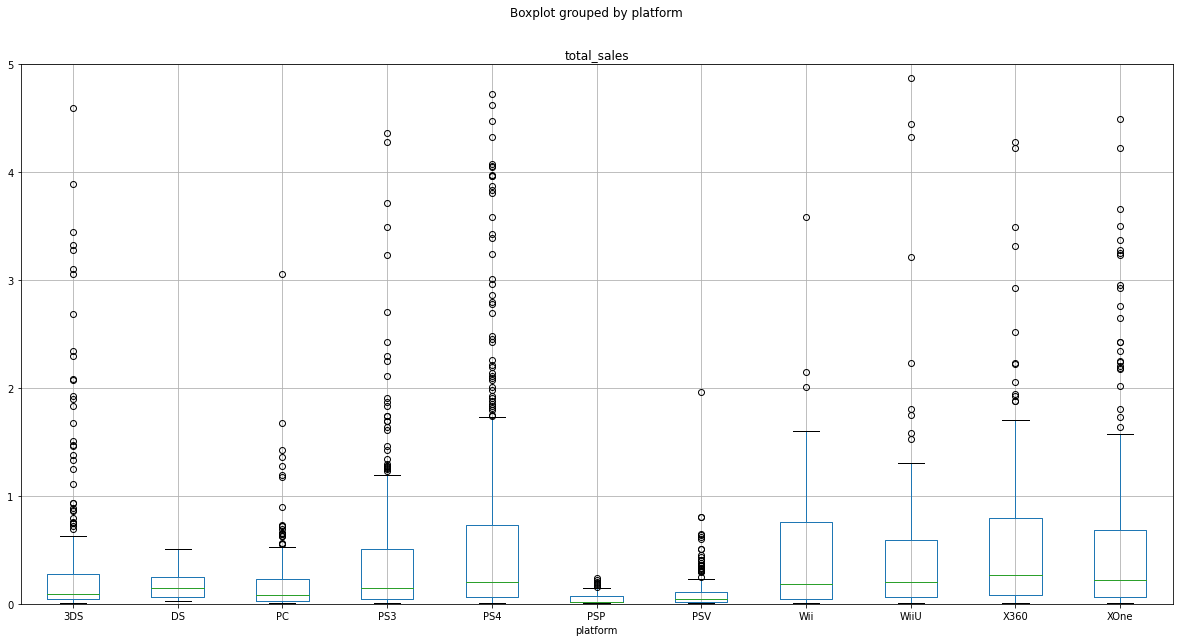

In [29]:
df.boxplot(column='total_sales', by='platform', figsize=(20,10))
plt.ylim(0,5)

Практически у всех приставок есть большое количество выбросов, что говорит о разнообразии игровой индустрии<br>
Среди аутсайдеров – `PSP`, `PSV`<br>
Лидеры за 2016 год `PS4` и `XOne` имеют множество выбросов за верхней границей графика и потенциал роста за счёт длины этой границы

**Проанализируем влияние отзывов критиков и пользователей на продажи игр популярной консоли – PS4**

In [30]:
# Построим сводную таблицу с общими продажами консоли и видами отзывов
ps4_piv = df[df['platform'] == 'PS4'].groupby('total_sales')[['critic_score', 'user_score']].mean()
ps4_piv

,critic_score,user_score
total_sales,,
0.01,22.200000,2.050000
0.02,30.206897,2.989655
0.03,34.357143,2.464286
0.04,43.166667,4.616667
0.05,38.315789,3.526316
...,...,...
7.66,83.000000,5.700000
7.98,-1.000000,-1.000000
8.58,82.000000,4.300000


In [31]:
ps4_piv.reset_index().corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.203490,0.074779
critic_score,0.203490,1.000000,0.929721
user_score,0.074779,0.929721,1.000000


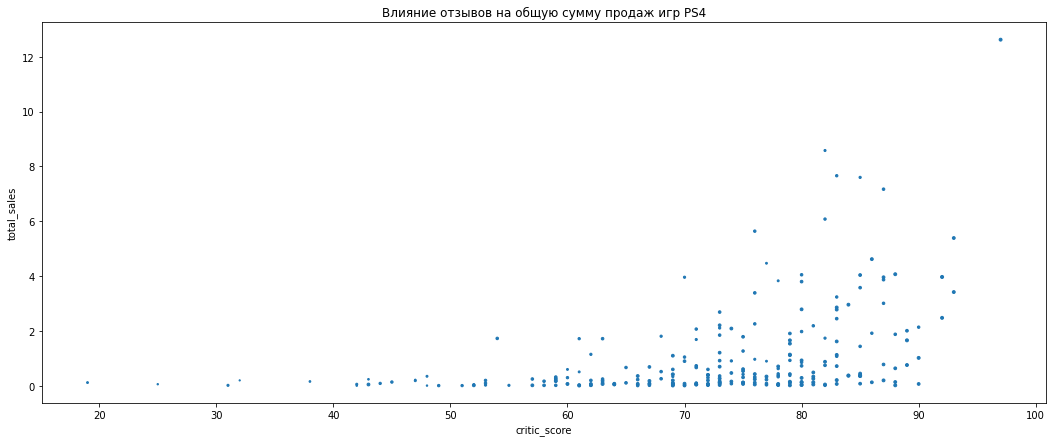

In [32]:
# Построим диаграмму рассеяния, где на оси x будут отзывы критиков, 
# на оси y – продажи, 
# а за размер точек будут отвечать отзывы пользователей
df[(df['platform'] == 'PS4') & (df['critic_score'] != -1)].plot.scatter(x='critic_score', y='total_sales', s='user_score', figsize=(18,7))
plt.title('Влияние отзывов на общую сумму продаж игр PS4');

Отзывы пользователей не имеют сильного влияния на суммы продаж,<br>
зато влияют отзывы критиков.<br>

Пороговой отметкой является оценка в `60 баллов`.<br>
Если оценка `ниже`, суммы **не растут**,<br>
если же `выше` – суммы приобретают **высокий разброс с тенденцией к росту**

**Сравним продажи игр PS4 и XOne c продажами игр других консолей**

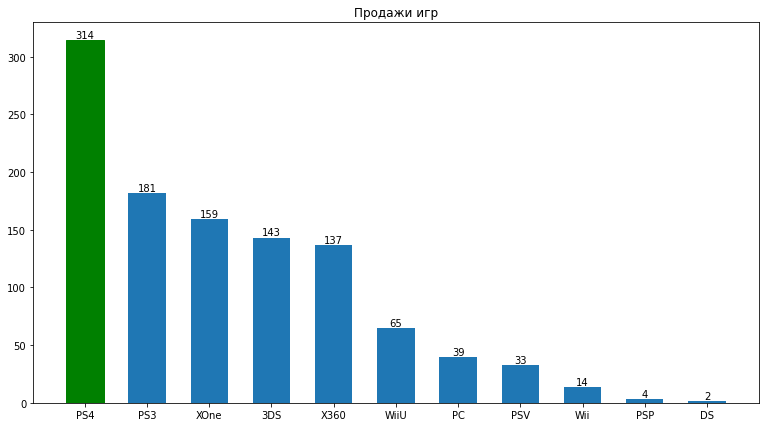

In [33]:
# Построим сводную таблицу с платформами и суммарными продажами
platforms_grouped = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Настроим и выведем столбчатый график
plt.figure(figsize=(13, 7))
barlist = plt.bar(platforms_grouped.index, platforms_grouped, width=0.6) # Уменьшим толщину баров
 
barlist[platforms_grouped.index.get_indexer(['PS4'])[0]].set_color('g') # Закрасим лидера – PS4

plt.bar_label(container=barlist, labels=(platforms_grouped.apply('{:.0f}'.format))) # Выведем округлённые значения
plt.title('Продажи игр')

plt.show()

3DS


user_score     0.241504
total_sales    1.000000
Name: total_sales, dtype: float64

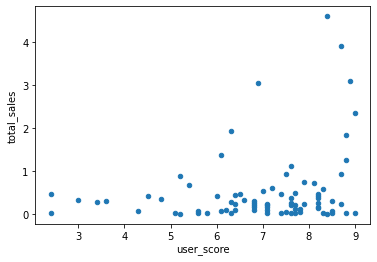

critic_score    0.357057
total_sales     1.000000
Name: total_sales, dtype: float64

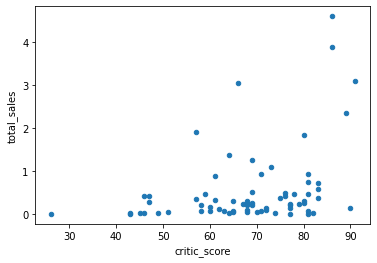

DS
Для платформы DS не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы DS не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
PC


user_score    -0.093842
total_sales    1.000000
Name: total_sales, dtype: float64

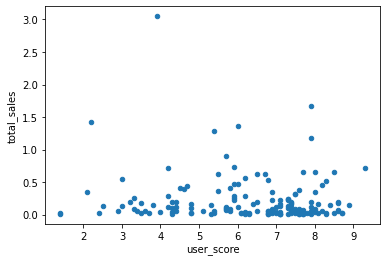

critic_score    0.19603
total_sales     1.00000
Name: total_sales, dtype: float64

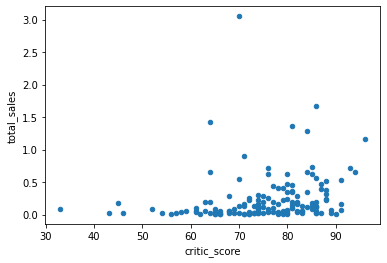

PS3


user_score     0.002394
total_sales    1.000000
Name: total_sales, dtype: float64

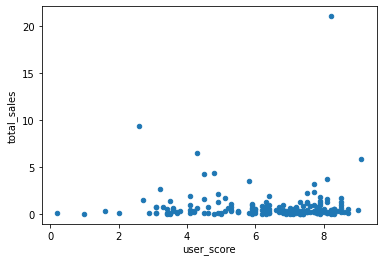

critic_score    0.334285
total_sales     1.000000
Name: total_sales, dtype: float64

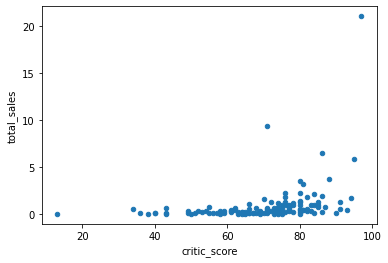

PS4


user_score    -0.031957
total_sales    1.000000
Name: total_sales, dtype: float64

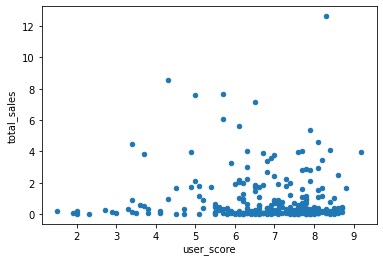

critic_score    0.406568
total_sales     1.000000
Name: total_sales, dtype: float64

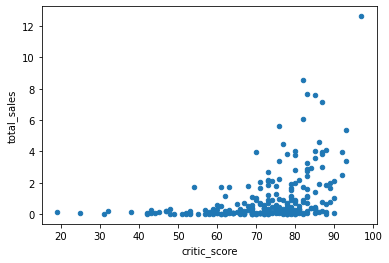

PSP
Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей
Для платформы PSP не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
PSV


user_score     0.000942
total_sales    1.000000
Name: total_sales, dtype: float64

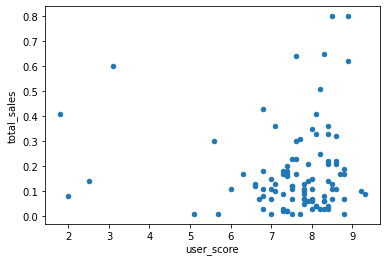

critic_score    0.254742
total_sales     1.000000
Name: total_sales, dtype: float64

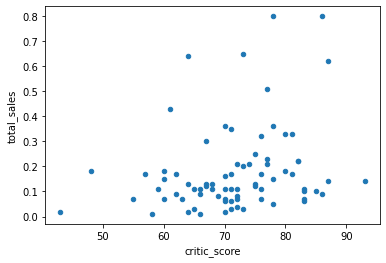

Wii


user_score     0.682942
total_sales    1.000000
Name: total_sales, dtype: float64

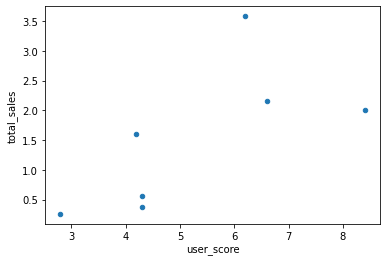

Для платформы Wii не хватает данных для построения диаграммы и расчета корреляции отзывов критиков
WiiU


user_score     0.41933
total_sales    1.00000
Name: total_sales, dtype: float64

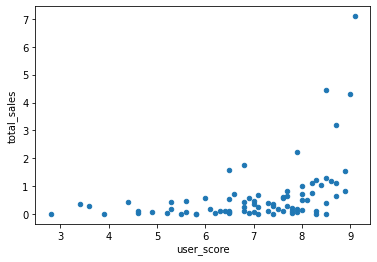

critic_score    0.376415
total_sales     1.000000
Name: total_sales, dtype: float64

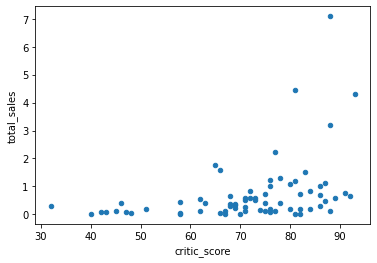

X360


user_score    -0.011742
total_sales    1.000000
Name: total_sales, dtype: float64

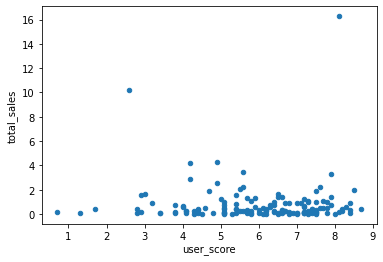

critic_score    0.350345
total_sales     1.000000
Name: total_sales, dtype: float64

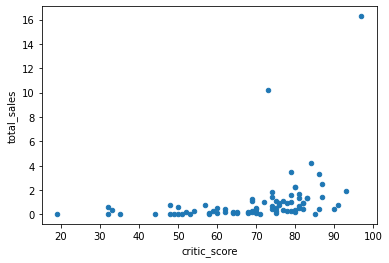

XOne


user_score    -0.068925
total_sales    1.000000
Name: total_sales, dtype: float64

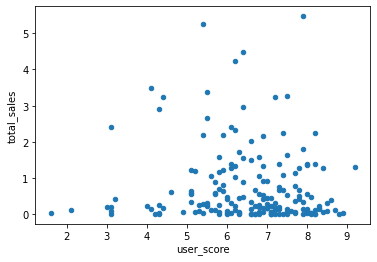

critic_score    0.416998
total_sales     1.000000
Name: total_sales, dtype: float64

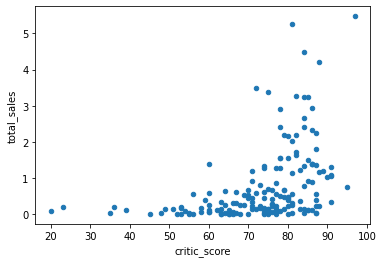

In [35]:
import matplotlib.pyplot as plt
df_sc, y = df, 'total_sales'
for platform, games_on_pl in df_sc.groupby('platform'):
    print('='*60)
    print(platform)
    # Считаем сколько в колонке не пустых отзывов
    not_user = len(games_on_pl[(games_on_pl.user_score != -1)&(games_on_pl['user_score'].notna() == True)])
    not_critic = len(games_on_pl[(games_on_pl.critic_score != -1)&(games_on_pl['user_score'].notna() == True)])
    sum_not = 2 # Задаем количество не пустых значений для вывода диаграммы и расчета корреляции
    if not_user > sum_not:
        games_on_pl[games_on_pl.user_score != -1].plot(kind='scatter', x='user_score', y=y)
        display(games_on_pl[games_on_pl.user_score != -1][['user_score', y]].corr()[y])
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов пользователей')
    if not_critic > sum_not:
        games_on_pl[games_on_pl.critic_score != -1].plot(kind='scatter', x='critic_score', y=y)
        display(games_on_pl[games_on_pl.critic_score != -1][['critic_score', y]].corr()[y])
        plt.show()
    else:
        print('Для платформы',platform, 'не хватает данных для построения диаграммы и расчета корреляции отзывов критиков')

**Проанализируем распределение игр по жанрам**

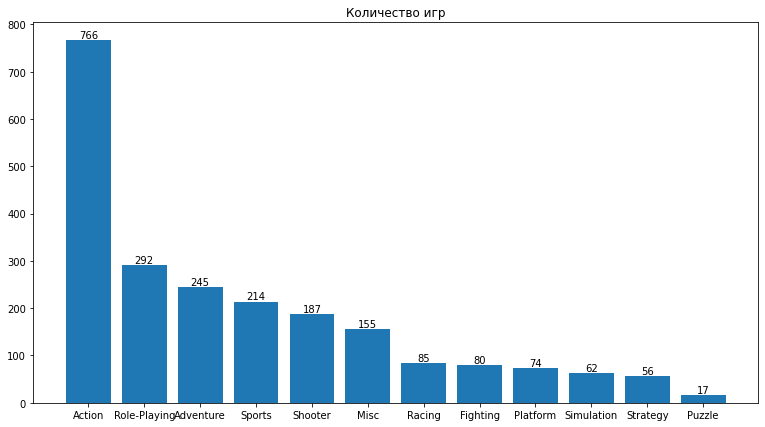

In [36]:
# Для начала посмотрим на количество выпущенных игр
genre_piv = df.groupby('genre')['name'].count().sort_values(ascending=False)

plt.figure(figsize=(13, 7))
container = plt.bar(genre_piv.index, genre_piv)
plt.bar_label(container=container, labels=genre_piv)
plt.title('Количество игр')
plt.show()

`Action` – **самый распространённый жанр**. Чаще всего он комбинируется с другими, чем, помимо увлекательности, и обусловлена его популярность.<br>
`Puzzle` – **наименее распространены**. Паззлы редко предпочитают более динамичным жанрам

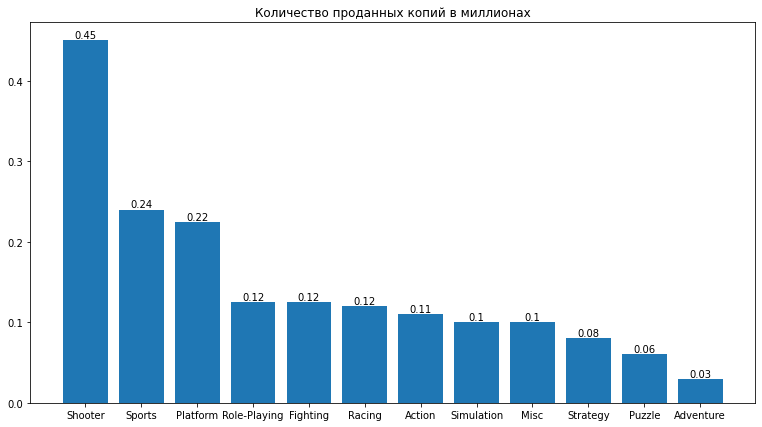

In [37]:
# Построим график жанров с точки зрения прибыльности
genre_piv = df.groupby('genre')['total_sales'].median().sort_values(ascending=False)

plt.figure(figsize=(13, 7))
container = plt.bar(genre_piv.index, genre_piv)
plt.bar_label(container=container, labels=[round(x,2) for x in genre_piv])
plt.title('Количество проданных копий в миллионах')
plt.show()

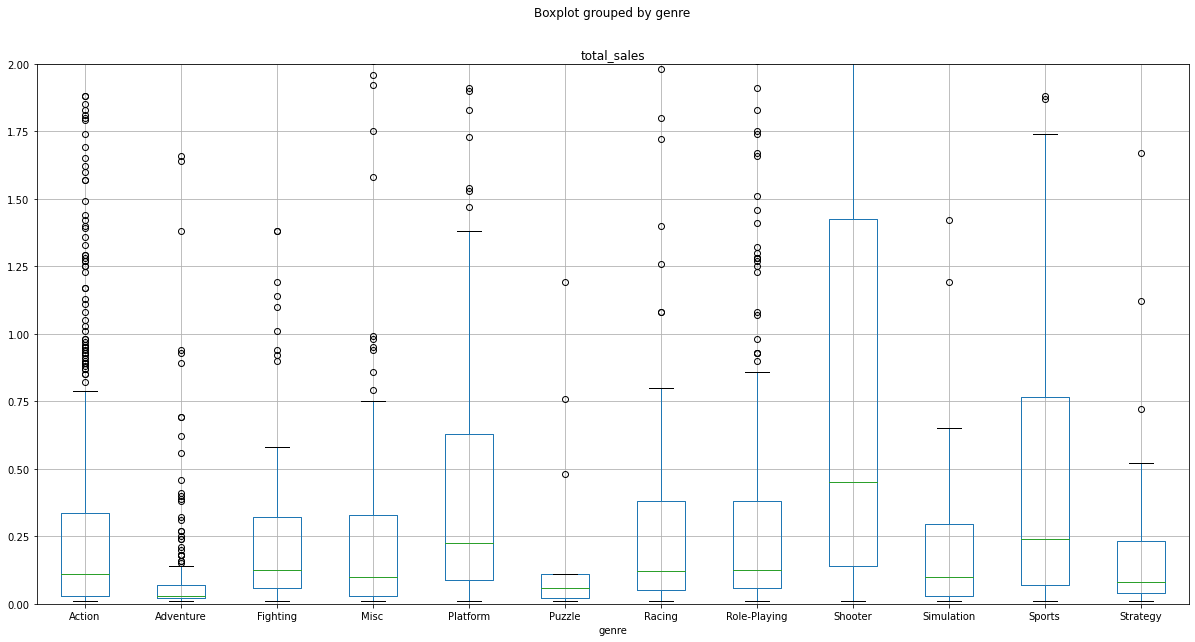

In [38]:
df.boxplot(column='total_sales', by='genre', figsize=(20,10))
plt.ylim(0,2);

`Shooter` выстрелил как наиболее стабильный жанр в отношении прибыльности<br> 
В 3 раза хуже дела обстоят со `Sports`, `Role-Playing` и другими жанрами

## Портрет пользователя каждого региона

**Выявим популярные платформы (топ-5) для каждого региона и опишем различия в долях продаж за актуальный период**

In [39]:
# Построим сводную таблицу по платформам в каждом регионе и объявим функцию,
# возвращающую доли продаж топ-5 платформ в указанном регионе и график 
platforms_piv = df.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
def top_platforms(region):
    top_5 = list(platforms_piv[region].sort_values(ascending=False).head().index)
    if region.startswith('eu'):
        platforms_piv[region].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 платформ в Европе');
    elif region.startswith('na'):
        platforms_piv[region].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 платформ в Северной Америке');
    elif region.startswith('jp'):
        platforms_piv[region].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 платформ в Японии');
    return round(platforms_piv.loc[top_5, region] / 
                 df.groupby('platform')['total_sales'].sum()[top_5], 2)

platform
PS4     0.45
PS3     0.37
XOne    0.32
X360    0.31
3DS     0.22
dtype: float64

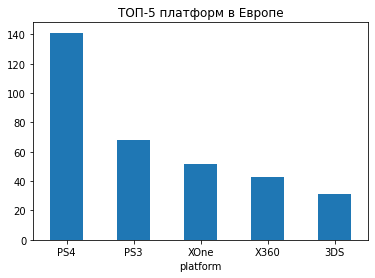

In [40]:
# Выведем информацию по пользователям Европы
top_platforms('eu_sales')

platform
PS4     0.35
XOne    0.58
X360    0.60
PS3     0.35
3DS     0.27
dtype: float64

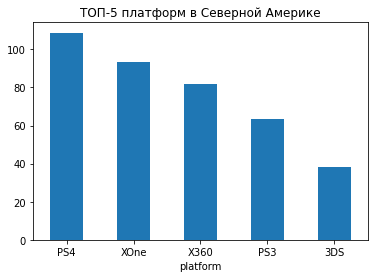

In [41]:
# Выведем информацию по пользователям Северной Америки
top_platforms('na_sales')

platform
3DS     0.47
PS3     0.13
PSV     0.56
PS4     0.05
WiiU    0.17
dtype: float64

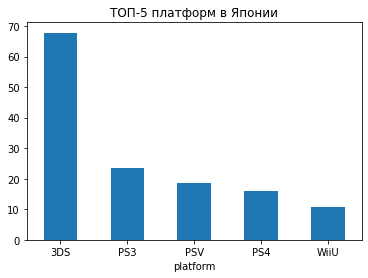

In [42]:
# Выведем информацию по пользователям Японии
top_platforms('jp_sales')

In [43]:
# Посмотрми на общий межрегиональный тренд по платформам
eu = set(platforms_piv['eu_sales'].sort_values(ascending=False).head().index)
na = set(platforms_piv['na_sales'].sort_values(ascending=False).head().index)
jp = set(platforms_piv['jp_sales'].sort_values(ascending=False).head().index)

eu & na & jp

{'3DS', 'PS3', 'PS4'}

- `В Европе и Северной Америке` наиболее популярные приставки: `PS4`, `XOne`<br>
- Самые яркое **отличие** – в популряной приставке `Японии`. Здесь лидер – `3DS`, а `XOne` не попал даже в 5 лучших. 
- **Общие межрегиональный тренды** – `PS4` и `3DS`<br>
- Доля продаж лидеров в Северной Америке и Европе выше, чем в Японии, **примерно в 2 раза**

**Проанализируем самые популярные жанры за последние два года**

In [44]:
# Построим сводную таблицу по жанрам в каждом регионе и объявим функцию,
# возвращающую доли продаж топ-5 жанров в указанном регионе и график 
genres_piv = df.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
def top_genres(region):
    top_5 = list(genres_piv[region].sort_values(ascending=False).head().index)
    if region.startswith('eu'):
        genres_piv[region].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 жанров в Европе');
    elif region.startswith('na'):
        genres_piv[region].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 жанров в Северной Америке');
    elif region.startswith('jp'):
        genres_piv[region].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 жанров в Японии');
    return round(genres_piv.loc[top_5, region] / 
                 df.groupby('genre')['total_sales'].sum()[top_5], 2)

In [45]:
genres_piv.style.highlight_max(color='#ADD8E6')

,eu_sales,jp_sales,na_sales
genre,,,
Action,118.130000,40.490000,126.050000
Adventure,8.250000,5.820000,7.140000
Fighting,8.550000,7.650000,15.550000
Misc,20.040000,9.200000,27.490000
Platform,15.580000,4.790000,18.140000
Puzzle,1.000000,1.180000,0.830000
Racing,20.190000,2.300000,12.960000
Role-Playing,36.970000,51.040000,46.400000
Shooter,87.860000,6.610000,109.740000


genre
Action          0.37
Shooter         0.38
Sports          0.40
Role-Playing    0.25
Racing          0.51
dtype: float64

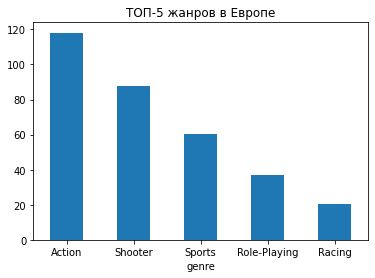

In [46]:
# Выведем информацию по пользователям Европы
top_genres('eu_sales')

genre
Action          0.39
Shooter         0.47
Sports          0.43
Role-Playing    0.32
Misc            0.44
dtype: float64

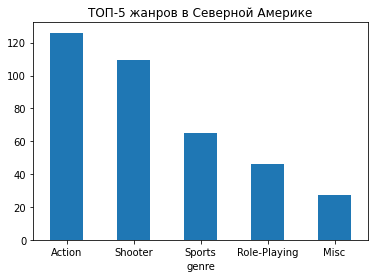

In [47]:
# Выведем информацию по пользователям Северной Америки
top_genres('na_sales')

genre
Role-Playing    0.35
Action          0.13
Misc            0.15
Fighting        0.22
Shooter         0.03
dtype: float64

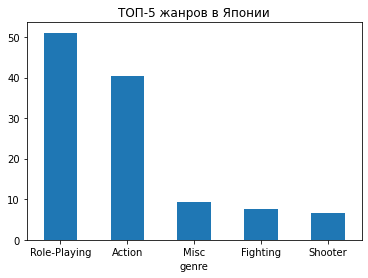

In [48]:
# Выведем информацию по пользователям Японии
top_genres('jp_sales')

In [49]:
# Посмотрим на общий межрегиональный тренд по жанрам
eu = set(genres_piv['eu_sales'].sort_values(ascending=False).head().index)
na = set(genres_piv['na_sales'].sort_values(ascending=False).head().index)
jp = set(genres_piv['jp_sales'].sort_values(ascending=False).head().index)

eu & na & jp

{'Action', 'Role-Playing', 'Shooter'}

- Популярные жанры `в Европе и Северной Америке` в 4 случаях из 5 **одинаковые**: `Shooter`, `Action`, `Sports`, `Role-Playing`<br>
- Самые яркие **отличия** – в популряных жанрах `Японии`. Здесь `Action` в 5 раз популярнее `Shooter`.
- **Общие межрегиональные тренды** – `Action`, `Shooter`, `Role-Playing`<br>
- Доля продаж жанров-лидеров в Северной Америке и Европе выше, чем в Японии, **примерно в 4-5 раз**

**Проанализируем, влияет ли рейтинг ESRB на продажи 2015-2016 гг. в регионах**

In [50]:
# Сгруппируем продажи в регионах по возрастным рейтингам
raiting_piv = df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()
raiting_piv.style.highlight_max(color='#ADD8E6')

,na_sales,eu_sales,jp_sales
rating,,,
0,89.420000,78.910000,85.050000
E,79.050000,83.360000,15.140000
E10+,54.240000,42.690000,5.890000
M,165.210000,145.320000,14.110000
T,49.790000,41.950000,20.590000


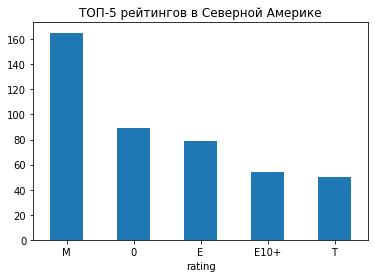

In [51]:
# Выведем график наиболее распространённых рейтингов в Северной Америке
raiting_piv['na_sales'].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 рейтингов в Северной Америке');

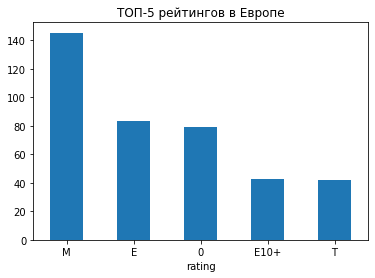

In [52]:
# Выведем график наиболее распространённых рейтингов в Европе
raiting_piv['eu_sales'].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 рейтингов в Европе');

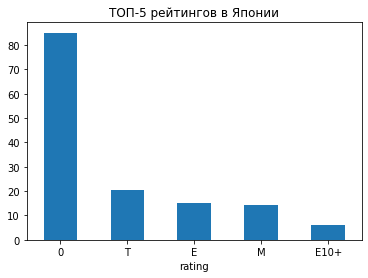

In [53]:
# Выведем график наиболее распространённых рейтингов в Японии
raiting_piv['jp_sales'].sort_values(ascending=False).head().plot.bar(rot=0, title='ТОП-5 рейтингов в Японии');

In [54]:
# Посмотрим на общий межрегиональный тренд по ограничениям
eu = set(raiting_piv['eu_sales'].sort_values(ascending=False).head().index)
na = set(raiting_piv['na_sales'].sort_values(ascending=False).head().index)
jp = set(raiting_piv['jp_sales'].sort_values(ascending=False).head().index)

eu & na & jp

{'0', 'E', 'E10+', 'M', 'T'}

По возрастным рейтингам продажи игр `в Северной Америке и Европе` вновь **не отличаются**. Лидируют игры для людей старше 17 лет, то есть рейтинг – `M`<br> 
`В Японии` же более **распространены новинки**, ещё не успевшие приобрести нужный рейтинг и поэтому выходящие под цензом `RP`<br>
У всех регионов по топ-5 ограничений одинаковые предпочтения

## Проверим гипотезы

H0: средние пользовательские рейтинги платформ Xbox One и PC одинаковые<br>
H1: средние пользовательские рейтинги платформ Xbox One и PC разные

In [55]:
XOne = df[df['platform'] == 'XOne']['user_score']
PC = df[df['platform'] == 'PC']['user_score']

alpha = .05

results = st.ttest_ind(XOne, PC, nan_policy='omit')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.20111399900783597
Не получилось отвергнуть нулевую гипотезу


H0: средние пользовательские рейтинги жанров Action и Sports одинаковые<br>
H1: средние пользовательские рейтинги жанров Action и Sports разные

In [56]:
Action = df[df['genre'] == 'Action']['user_score']
Sports = df[df['genre'] == 'Sports']['user_score']

alpha = .05

results = st.ttest_ind(Action, Sports, nan_policy='omit')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.02193663336455412
Отвергаем нулевую гипотезу


Исходя из рузультатов статистического анализа, мы можем сделать вывод:<br>
гипотеза о тождестве средних пользовательских рейтингов жанров Action и Sports **не подтверждается**,<br>
гипотеза о тождестве средних пользовательских рейтингов платформ XOne и PC **не отвергается**

Нулевые гипотезы были сформулированы таким образом, что изначально исследуется равноство необходимых средних.<br>
Альтернативные гипотезы сформулированы через разность, то есть нами взяты двусторонние гипотезы<br>

Для проверки гипотез был использован критерий Стьюдента для несвязанных выборок (independent), поскольку мы имеем дело с выборками разных генеральных совокупностей

## Общий вывод

Нам как интернет-магазину видеоигр необходимо обозначить выявленные тренды игровой индустрии последних лет. Принять верные финансовые решения о закупке игр мы сможем лишь с учётом региональных предпочтений.

**Северная Америка и Европа по предпочтениям в приставках, жанрах и возрастных рейтингах практически схожи, в отличие от Японии**

*Платформы*
- Северная Америка и Европа предпочитают `PS4` и `XOne`, Япония – `3DS`, а вот `XOne` у японцев не попадает даже в топ-5.
- Все регионы сходятся по популярности платформ на `PS4` и `3DS`

*Жанры*
- Северная Америка и Европа предпочитают `Shooter`, `Action`, `Sports`, `Role-Playing`<br>
- В Японии Action популярнее, чем Shooter, в 5 раз
- Все регионы сходятся по поулярности жанров на `Action`, `Shooter`, `Role-Playing`
- Доля продаж жанров-лидеров в Северной Америке и Европе выше, чем в Японии, **примерно в 4-5 раз**

*Возрастные ограничения*
- В Северной Америке и Европе наипопулярнейший рейтинг игр – `M`(старше 17 лет)
- В Японии – `RP`(пока неопределённый)

---

Гипотеза о тождестве средних оценок пользователей `Action` и `Sports` не подтверждается<br>
Гипотеза о тождестве средних оценок пользователей `XOne` и `PC` не подтверждается